In [ ]:
# This notebook is a copy similar to ALR_Client_Side found in:
# https://github.com/rfernand387/ALR_Earth_Engine/blob/master/ALR_Client_Side.ipynb

# Modifications have been made to accept an EE image with 10 m resolution bands that has been outputted from SL2P10_control.ipynb:
# https://github.com/kateharvey/Sentinel2_ALR/blob/main/shared/SL2P10_control.ipynb

In [1]:
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn import preprocessing
from sklearn import linear_model
import tensorflow
import ee
import json
from collections import OrderedDict
import time
import math
import csv
import os

# custom module
import ALR_functions as alr

In [2]:
# Authorize the script with Earth Engine using the credentials.json file. Ensure either ee.Authenticate() has been called in a previous
# script or the "$ earthengine authenticate" command has been run in the environment to set up the credentials.json file
# The google account you provide during the authentication flow must have received access to Google Earth Engine
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AX4XfWiKZr2j8JGdeXbcU4n5wjsyXMQ-3PFk29xudgWawHZW2SR1F1CG3LM



Successfully saved authorization token.


In [3]:
# Set the test image using an uploaded asset for now
testImage = ee.Image('users/kateharvey/TestImage')

# Change variable name here to match band name pattern (one of: Albedo, fAPAR, fCOVER, LAI, CCC, CWC, DASF)
outputName = 'LAI'
defaultBand = 'estimate'+outputName

# Select bands to create 20m and 10m images
inputImage = ee.Image(testImage.select(0,1,2,3,4,5,6,7,8,9,10,11,23,27,28,29,30,31,32,33))
inputImage_10m = ee.Image(testImage.select(1,2,3,7,23,27,28,29,30,31,32,33))

# List the bands that we expect in the image (ensure number of bands in the list below matches the number bands in the input image)
# This is the order of bands produced by running SL2P10 and exporting the resulting ImageCollection
inputImage_bands = ee.List(['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'date', 'QC', 'estimateLAI', 'partition', 'networkID', 'errorLAI', 'partition_1', 'networkID_1'])
inputImage_bands_10m = ee.List(['B2', 'B3', 'B4', 'B8', 'date', 'QC', 'estimateLAI', 'partition', 'networkID', 'errorLAI', 'partition_1', 'networkID_1'])

### Vegetation Indices Sources

1. https://www.hindawi.com/journals/js/2017/1353691/tab1/
2. https://www.hiphen-plant.com/blog/vegetation-indices/
3. https://gisgeography.com/sentinel-2-bands-combinations/

In [4]:
# Below we define a list of strings representing the expressions for each vegetation index as a function of the bands in the input image
# More vegetation indices can be defined, but the list CANNOT contain any two vegetation indices which are a linear combination of each
# other or LARs will fail to select the requested number of variables

# The formatting of the expression must be
# "<name of VI> = <expression with band names from inputImage_bands used as variables in the form b('<band name>')"

# Only include VIs that use 10 m bands (B2, B3, B4, B8)
input_VI_definition_10m = ee.List(["RAW_B2  = b('B2')",
                                   "RAW_B3  = b('B3')",
                                   "RAW_B4  = b('B4')",
                                   "RAW_B8  = b('B8')",
                                   "GI      = b('B3')/b('B4')",
                                 # "RVI3    = b('B4')/b('B6')",
                                 # "SR3     = b('B5')/b('B4')",
                                 # "GM1     = b('B6')/b('B3')",
                                 # "GM2     = b('B6')/b('B5')",
                                 # "SR2     = b('B7')/b('B3')",
                                 # "PSSR    = b('B7')/b('B4')",
                                   "SGI     = b('B8')/b('B4')",
                                 # "MSI     = b('B11')/b('B7')",
                                 # "II      = b('B11')/b('B12')",
                                   "GVI     = (b('B8')/b('B3'))-1",
                                 # "PSRI    = (b('B4')-b('B3'))/b('B6')",
                                   "NDVI3   = ((b('B8')-b('B4'))/(b('B8')))+b('B4')",
                                 # "SR5     = 1/b('B5')",
                                 # "SR6     = b('B4')/(b('B3')*b('B5'))",
                                 # "SR7     = b('B8')/(b('B3')*b('B5'))",
                                 # "IPVI    = b('B7')/(b('B7')+b('B4'))",
                                 # "ARI     = (1/b('B3'))-(1/b('B5'))",
                                 # "ARI2    = b('B7')*((1/b('B3'))-(1/b('B5')))",
                                   "NDVI    = (b('B8')-b('B4'))/(b('B8')+b('B4'))",
                                   "GNDVI   = (b('B8')-b('B3'))/(b('B8')+b('B3'))",
                                 # "NDWI    = (b('B8')-b('B11'))/(b('B8')+b('B11'))",
                                 # "NDREVI  = (b('B8')-b('B5'))/(b('B8')+b('B5'))",
                                   "NDGI    = (b('B3')-b('B4'))/(b('B3')+b('B4'))",
                                 # "NDI1    = (b('B7')-b('B5'))/(b('B7')-b('B4'))",
                                 # "NDI2    = (b('B8')-b('B5'))/(b('B8')-b('B4'))",
                                 # "RENDVI  = (b('B6')-b('B5'))/(b('B6')+b('B5'))",
                                 # "OSAVI   = (1.16*(b('B7')-b('B4')))/(b('B7')+b('B4')+0.61)",
                                 # "NMDI    = (b('B8')-(b('B11')-b('B12')))/(b('B8')+(b('B11')-b('B12')))",
                                 # "HI      = ((b('B3')-b('B5'))/(b('B3')+b('B5')))-0.5*b('B5')",
                                 # "GVSP    = (-0.283*b('B3') - 0.66*b('B4') + 0.577*b('B6') + 0.388*b('B8'))/(0.433*b('B3') - 0.632*b('B4') + 0.586*b('B6') + 0.264*b('B8A'))",
                                 # "MCARI   = ((b('B5')-b('B4'))-0.2*(b('B5')-b('B3')))*(b('B5')/b('B4'))",
                                 # "TCARI   = 3*((b('B5')-b('B4'))-0.2*(b('B5')-b('B3'))*(b('B5')/b('B4')))",
                                   "EVI     = 2.5*((b('B8')-b('B4'))/(b('B8')+6*b('B4')-7.5*b('B3')+1))",
                                   "EVI2    = 2.5*((b('B8')-b('B4'))/(b('B8')+2.4*b('B4')+1))",
                                   "RDVI    = (b('B8')-b('B4'))/((b('B8')+b('B4'))**0.5)",
                                   "MSR     = ((b('B8')/b('B4'))-1)/((b('B8')/b('B4'))**0.5+1)",
                                 # "MSAVI   = 0.5*(2*b('B7')+1-((2*b('B7')+1)**2-8*(b('B7')-b('B4')))**0.5)",
                                   "MSAVI2  = 0.5*(2*b('B8')+1-((2*b('B8')+1)**2-8*(b('B8')-b('B4')))**0.5)",
                                 # "MCARI2  = (1.5*(2.5*(b('B7')-b('B4'))-1.3*(b('B7')-b('B3'))))/((((2*b('B7')+1)**2)-(6*b('B7')-5*(b('B4')**0.5))-0.5)**0.5)",
                                 # "MTVI2   = (1.5*(1.2*(b('B7')-b('B3'))-2.5*(b('B4')-b('B3'))))/(((2*b('B7')+1)**2-(6*b('B7')-5*b('B4'))-0.5)**0.5)",
                                 # "MSR2    = ((b('B7')/b('B4'))-1)/(((b('B7')/b('B4'))+1)**0.5)",
                                   "NLI     = ((b('B8')**2)-b('B4'))/((b('B8')**2)+b('B4'))"])


input_VI_definition = ee.List(["GI      = b('B3')/b('B4')",
                              "RVI3    = b('B4')/b('B6')",
                              "SR3     = b('B5')/b('B4')",
                              "GM1     = b('B6')/b('B3')",
                              "GM2     = b('B6')/b('B5')",
                              "SR2     = b('B7')/b('B3')",
                              "PSSR    = b('B7')/b('B4')",
                              "SGI     = b('B8A')/b('B4')",
                              "MSI     = b('B11')/b('B7')",
                              "II      = b('B11')/b('B12')",
                              "GVI     = (b('B8A')/b('B3'))-1",
                              "PSRI    = (b('B4')-b('B3'))/b('B6')",
                              "NDVI3   = ((b('B8A')-b('B4'))/(b('B8A')))+b('B4')",
                              "SR5     = 1/b('B5')",
                              "SR6     = b('B4')/(b('B3')*b('B5'))",
                              "SR7     = b('B8A')/(b('B3')*b('B5'))",
                              "IPVI    = b('B7')/(b('B7')+b('B4'))",
                              "ARI     = (1/b('B3'))-(1/b('B5'))",
                              "ARI2    = b('B7')*((1/b('B3'))-(1/b('B5')))",
                              "NDVI    = (b('B8A')-b('B4'))/(b('B8A')+b('B4'))",
                              "GNDVI   = (b('B8A')-b('B3'))/(b('B8A')+b('B3'))",
                              "NDWI    = (b('B8A')-b('B11'))/(b('B8A')+b('B11'))",
                              "NDREVI  = (b('B8A')-b('B5'))/(b('B8A')+b('B5'))",
                              "NDGI    = (b('B3')-b('B4'))/(b('B3')+b('B4'))",
                              "NDI1    = (b('B7')-b('B5'))/(b('B7')-b('B4'))",
                              "NDI2    = (b('B8A')-b('B5'))/(b('B8A')-b('B4'))",
                              "RENDVI  = (b('B6')-b('B5'))/(b('B6')+b('B5'))",
                              "OSAVI   = (1.16*(b('B7')-b('B4')))/(b('B7')+b('B4')+0.61)",
                              "NMDI    = (b('B8A')-(b('B11')-b('B12')))/(b('B8A')+(b('B11')-b('B12')))",
                              "HI      = ((b('B3')-b('B5'))/(b('B3')+b('B5')))-0.5*b('B5')",
                              "GVSP    = (-0.283*b('B3') - 0.66*b('B4') + 0.577*b('B6') + 0.388*b('B8A'))/(0.433*b('B3') - 0.632*b('B4') + 0.586*b('B6') + 0.264*b('B8A'))",
                              "MCARI   = ((b('B5')-b('B4'))-0.2*(b('B5')-b('B3')))*(b('B5')/b('B4'))",
                              "TCARI   = 3*((b('B5')-b('B4'))-0.2*(b('B5')-b('B3'))*(b('B5')/b('B4')))",
                              "EVI     = 2.5*((b('B8A')-b('B4'))/(b('B8A')+6*b('B4')-7.5*b('B3')+1))",
                              "EVI2    = 2.5*((b('B8A')-b('B4'))/(b('B8A')+2.4*b('B4')+1))",
                              "RDVI    = (b('B8A')-b('B4'))/((b('B8A')+b('B4'))**0.5)",
                              "MSR     = ((b('B8A')/b('B4'))-1)/((b('B8A')/b('B4'))**0.5+1)",
                              "MSAVI   = 0.5*(2*b('B7')+1-((2*b('B7')+1)**2-8*(b('B7')-b('B4')))**0.5)",
                              "MSAVI2  = 0.5*(2*b('B8A')+1-((2*b('B8A')+1)**2-8*(b('B8A')-b('B4')))**0.5)",
                              "MCARI2  = (1.5*(2.5*(b('B7')-b('B4'))-1.3*(b('B7')-b('B3'))))/((((2*b('B7')+1)**2)-(6*b('B7')-5*(b('B4')**0.5))-0.5)**0.5)",
                              "MTVI2   = (1.5*(1.2*(b('B7')-b('B3'))-2.5*(b('B4')-b('B3'))))/(((2*b('B7')+1)**2-(6*b('B7')-5*b('B4'))-0.5)**0.5)",
                              "MSR2    = ((b('B7')/b('B4'))-1)/(((b('B7')/b('B4'))+1)**0.5)",
                              "NLI     = ((b('B8A')**2)-b('B4'))/((b('B8A')**2)+b('B4'))"])

In the following functions each input is recast to the expected data type as function parameter typing is not enforced in Earth Engine
when defining functions, and later methods called on these parameters within the function must recognize the type of the parameter
independently of other code

### Process images and and run LARS:

In [5]:
inputImage = alr.format_image(inputImage, inputImage_bands, defaultBand, input_VI_definition)
inputImage_10m = alr.format_image(inputImage_10m, inputImage_bands_10m, defaultBand, input_VI_definition_10m)

In [6]:
num_input_pixels = alr.get_num_pixels(inputImage)

In [7]:
scaledImage = alr.scale_image(inputImage, defaultBand)
scaledImage_10m = alr.scale_image(inputImage_10m, defaultBand)

In [8]:
select_features = alr.ee_LARS(scaledImage, defaultBand, 5, 5000)
select_features_10m = alr.ee_LARS(scaledImage_10m, defaultBand, 5, 5000)

Currently the trimmed data is processed then in a neural network created using tensorflow to find nonlinear relationships between the predictor and the response. Earth Engine does not have this functionality (for free) to generate neural network based models.

Here we also see how the server side in the Earth Engine API is completely separate from the client side on the local machine. We need
to export our trimmed data as a CSV to a google drive which is synced into the "gdrive" folder in our local machine using the 
Backup and Sync software or using google-drive-ocamlfuse on Linux

### Export CSV of 20m data:

In [16]:
trimmed_collection=alr.trim_data(image=inputImage.updateMask(inputImage.select(defaultBand).gt(0)),
                                 selected_features=select_features,
                                 response_band="estimateLAI",
                                 num_samples=50000,
                                 num_partitions=10)

# Creating the export task on the server side from Earth Engine. Remember that the data will be exported to the google drive of the google
# account you used when you initiated the Earth Engine API authentication flow, so ensure that, that accounts drive is synced to the 
# gdrive folder in the same folder as this script
exportData = ee.batch.Export.table.toDrive(collection=trimmed_collection, description="image_data_samples", fileFormat="CSV")

# Starting the export data task
exportData.start()

In [10]:
# Essentially a wait loop to see if the data has finished exporting by checking with the server-side
prev_task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
print(prev_task_status)
while exportData.active():
    task_status = ee.data.getTaskStatus(exportData.id)[0]["state"]
    if(task_status != prev_task_status):
        print(task_status)
    prev_task_status = task_status
    time.sleep(5)
print(ee.data.getTaskStatus(exportData.id)[0]["state"])

READY
RUNNING
COMPLETED


In [11]:
# Reading the CSV file into dataframes
trimmed_data = pd.read_csv('./gdrive/image_data_samples.csv')
X = trimmed_data.drop(labels=['estimateLAI', 'system:index', '.geo'], axis=1)
# X = trimmed_data.drop(labels=['LAI', 'system:index', '.geo'], axis=1)
y = trimmed_data.estimateLAI

# We preprocess the input features by standardizing them to a mean of 0 and a standard deviation of 1 for the neural network
X = pd.DataFrame(sklearn.preprocessing.scale(X))

In [12]:
# Using Keras to create a sequential model neural network which only has simple dense layers of the specified number of nodes
LAI_model = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(5, input_shape=[len(X.keys())]),
    tensorflow.keras.layers.Dense(4, activation="softsign"),
    tensorflow.keras.layers.Dense(3, activation="softsign"),
    tensorflow.keras.layers.Dense(2, activation="softsign"),
    tensorflow.keras.layers.Dense(1)
])
# Compiling the model to minimize the mean squared error loss function and use the NADAM optimizer
LAI_model.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

2021-10-22 16:30:17.640815: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Fitting the model to our trimmed data
LAI_model.fit(x=X.to_numpy(), y=y.to_numpy(), epochs=100)

2021-10-22 16:30:17.825991: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/100
920/920 [==============================] - 4s 2ms/step - loss: 7749530.3377 - mse: 7749530.3377 - mae: 2630.4939
Epoch 2/100
920/920 [==============================] - 2s 3ms/step - loss: 7815571.3355 - mse: 7815571.3355 - mae: 2643.2294
Epoch 3/100
920/920 [==============================] - ETA: 0s - loss: 7729195.3011 - mse: 7729195.3011 - mae: 2626.26 - 2s 3ms/step - loss: 7729286.5136 - mse: 7729286.5136 - mae: 2626.2907
Epoch 4/100
920/920 [==============================] - 2s 3ms/step - loss: 7754789.8849 - mse: 7754789.8849 - mae: 2630.8915
Epoch 5/100
920/920 [==============================] - 3s 3ms/step - loss: 7700394.5999 - mse: 7700394.5999 - mae: 2621.6605
Epoch 6/100
920/920 [==============================] - 2s 2ms/step - loss: 7681519.0575 - mse: 7681519.0575 - mae: 2619.4029: 1s - loss:
Epoch 7/100
920/920 [==============================] - 2s 2ms/step - loss: 7715765.7231 - mse: 7715765.7231 - mae: 2624.0478
Epoch 8/100
920/920 [==========================

In [14]:
# Predicting our own input data to evaluate the performance (for now)
LAI_predictions = pd.Series(LAI_model.predict(X.to_numpy()).flatten())

### Repeat export for 10 m data:

In [15]:
exportData_10m = ee.batch.Export.table.toDrive(collection=alr.trim_data(image=inputImage_10m.updateMask(inputImage_10m.select(defaultBand).gt(0)), selected_features=select_features_10m, response_band="estimateLAI", num_samples=50000, num_partitions=10),
                                           description="image_data_samples_10m",
                                           fileFormat="CSV")

exportData_10m.start()

In [16]:
# Essentially a wait loop to see if the data has finished exporting by checking with the server-side
prev_task_status_10m = ee.data.getTaskStatus(exportData_10m.id)[0]["state"]
print(prev_task_status_10m)
while exportData_10m.active():
    task_status_10m = ee.data.getTaskStatus(exportData_10m.id)[0]["state"]
    if(task_status_10m != prev_task_status_10m):
        print(task_status_10m)
    prev_task_status_10m = task_status_10m
    time.sleep(5)
print(ee.data.getTaskStatus(exportData_10m.id)[0]["state"])

READY
RUNNING
COMPLETED


In [28]:
# Reading the CSV file into dataframes
trimmed_data_10m = pd.read_csv('./gdrive/image_data_samples_10m.csv')
X_10m = trimmed_data_10m.drop(labels=['estimateLAI', 'system:index', '.geo'], axis=1)
# X_10m = trimmed_data_10m.drop(labels=['LAI', 'system:index', '.geo'], axis=1)
y_10m = trimmed_data_10m.estimateLAI

# We preprocess the input features by standardizing them to a mean of 0 and a standard deviation of 1 for the neural network
X_10m = pd.DataFrame(sklearn.preprocessing.scale(X_10m))

In [29]:
# Using Keras to create a sequential model neural network which only has simple dense layers of the specified number of nodes
LAI_model_10m = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Dense(5, input_shape=[len(X_10m.keys())]),
    tensorflow.keras.layers.Dense(4, activation="softsign"),
    tensorflow.keras.layers.Dense(3, activation="softsign"),
    tensorflow.keras.layers.Dense(2, activation="softsign"),
    tensorflow.keras.layers.Dense(1)
])
# Compiling the model to minimize the mean squared error loss function and use the NADAM optimizer
LAI_model_10m.compile(
    optimizer=tensorflow.keras.optimizers.Nadam(),
    loss='mse',
    metrics=['mse', 'mae'])

In [30]:
# Fitting the model to our trimmed data
LAI_model_10m.fit(x=X_10m.to_numpy(), y=y_10m.to_numpy(), epochs=100)

Epoch 1/100
920/920 [==============================] - 4s 3ms/step - loss: 7775097.5744 - mse: 7775097.5744 - mae: 2636.5415
Epoch 2/100
920/920 [==============================] - 3s 3ms/step - loss: 7765253.7269 - mse: 7765253.7269 - mae: 2633.8835
Epoch 3/100
920/920 [==============================] - 2s 2ms/step - loss: 7744142.0635 - mse: 7744142.0635 - mae: 2627.6154
Epoch 4/100
920/920 [==============================] - 2s 2ms/step - loss: 7728986.2997 - mse: 7728986.2997 - mae: 2626.1004
Epoch 5/100
920/920 [==============================] - 3s 4ms/step - loss: 7704136.9126 - mse: 7704136.9126 - mae: 2623.7105
Epoch 6/100
920/920 [==============================] - 3s 3ms/step - loss: 7666167.0831 - mse: 7666167.0831 - mae: 2613.0599
Epoch 7/100
920/920 [==============================] - 3s 4ms/step - loss: 7681847.8181 - mse: 7681847.8181 - mae: 2617.2612
Epoch 8/100
920/920 [==============================] - 3s 3ms/step - loss: 7634738.3474 - mse: 7634738.3474 - mae: 2610.4953


In [31]:
# Predicting our own input data to evaluate the performance (for now)
LAI_predictions_10m = pd.Series(LAI_model_10m.predict(X_10m.to_numpy()).flatten())

Below is code the that prepares the predictions to be displayed against the true values of the response for matplotlib

In [43]:
xy_tf_LAI = np.vstack([y, LAI_predictions])
z_tf_LAI = scipy.stats.gaussian_kde(xy_tf_LAI)(xy_tf_LAI)

idx_tf_LAI = z_tf_LAI.argsort()
x_tf_LAI = y[idx_tf_LAI]
y_tf_LAI = LAI_predictions[idx_tf_LAI]
z_tf_LAI = z_tf_LAI[idx_tf_LAI]

rmse_tf_LAI = sklearn.metrics.mean_squared_error(x_tf_LAI, y_tf_LAI, squared=False)

In [34]:
# 10m:
xy_tf_LAI_10m = np.vstack([y_10m, LAI_predictions_10m])
z_tf_LAI_10m = scipy.stats.gaussian_kde(xy_tf_LAI_10m)(xy_tf_LAI_10m)

idx_tf_LAI_10m = z_tf_LAI_10m.argsort()
x_tf_LAI_10m = y_10m[idx_tf_LAI_10m]
y_tf_LAI_10m = LAI_predictions_10m[idx_tf_LAI_10m]
z_tf_LAI_10m = z_tf_LAI_10m[idx_tf_LAI_10m]

rmse_tf_LAI_10m = sklearn.metrics.mean_squared_error(x_tf_LAI_10m, y_tf_LAI_10m, squared=False)

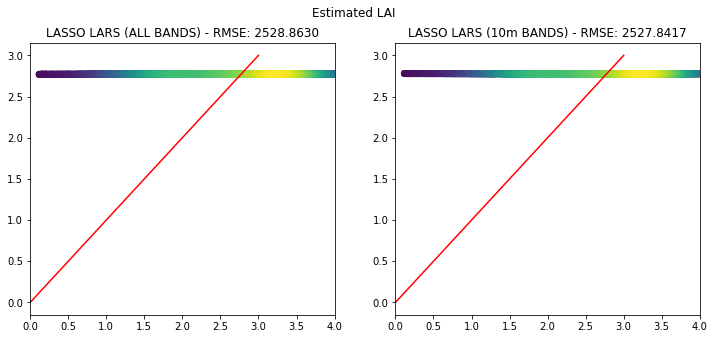

In [58]:
#---------------------------------------
# TO FIX: problem with plot data scaling
#---------------------------------------

# plot feature prediction
a_tf_LAI = np.linspace(0, 3, 1000)
a_tf_LAI_10m = np.linspace(0, 3, 1000)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('{}'.format('Estimated '+outputName))

# Using all features
ax[0].scatter(x_tf_LAI/1000, y_tf_LAI/100, c=z_tf_LAI)
ax[0].plot(a_tf_LAI, a_tf_LAI, c='r')
ax[0].set_xlim([0, 4])
ax[0].title.set_text(f'LASSO LARS (ALL BANDS) - RMSE: {rmse_tf_LAI:.4f}')

# Using 10 m features only
ax[1].scatter(x_tf_LAI_10m/1000, y_tf_LAI_10m/100, c=z_tf_LAI_10m)
ax[1].plot(a_tf_LAI_10m, a_tf_LAI_10m, c='r')
ax[1].set_xlim([0, 4])
ax[1].title.set_text(f'LASSO LARS (10m BANDS) - RMSE: {rmse_tf_LAI_10m:.4f}')

Early attempts to use the output of the kerasModel.get_weights() to apply the neural network weights manually

In [46]:
LAI_model.get_weights()

[array([[-2.7398798 , -3.536974  ,  3.6466925 ,  3.1230073 , -3.8034012 ],
        [ 3.7981048 ,  4.057477  , -2.9011967 , -3.9306624 ,  3.8486443 ],
        [ 0.02518088, -0.47988126,  0.55527914, -0.6205802 ,  0.0221141 ],
        [ 6.573537  ,  6.4667497 , -5.791895  , -6.8965282 ,  5.579861  ],
        [-1.60505   , -0.7643096 ,  1.0398248 ,  1.0449996 , -0.17405012]],
       dtype=float32),
 array([ 62.107056,  67.03532 , -62.11858 , -65.91176 ,  60.563435],
       dtype=float32),
 array([[-58.117756,  60.90686 ,  56.89272 ,  57.115055],
        [-60.49769 ,  62.267223,  60.218987,  61.560387],
        [ 59.326492, -59.18705 , -57.18816 , -57.682053],
        [ 60.810936, -63.179443, -59.603443, -60.579227],
        [-58.362484,  59.049206,  58.17094 ,  57.17671 ]], dtype=float32),
 array([-20.77999 ,  24.04258 ,  19.182133,  20.828087], dtype=float32),
 array([[-80.09378 ,  79.59881 , -80.34347 ],
        [ 80.74922 , -78.71333 ,  80.72042 ],
        [ 80.38256 , -79.88559 ,  81.

In [47]:
LAI_model_10m.get_weights()

[array([[-3.5480783 , -3.587339  , -2.9099941 ,  3.23489   , -3.628387  ],
        [ 4.1115007 ,  3.479523  ,  3.4047341 , -3.6032658 ,  4.029607  ],
        [ 0.04047   , -0.5622287 ,  0.07578439,  0.3330413 , -0.15563202],
        [ 5.4377503 ,  6.017694  ,  6.564209  , -6.8837156 ,  6.443043  ],
        [-1.0541114 , -0.5267082 , -0.9121629 ,  0.8634612 , -1.256864  ]],
       dtype=float32),
 array([ 63.259457,  60.774723,  64.13925 , -64.7012  ,  65.45289 ],
       dtype=float32),
 array([[ 57.933575, -62.39044 ,  58.880077,  58.378788],
        [ 57.8774  , -56.40682 ,  56.409847,  56.22585 ],
        [ 59.637047, -61.732967,  58.115383,  59.79154 ],
        [-58.200294,  60.5797  , -60.17792 , -58.306473],
        [ 58.961052, -61.74353 ,  59.353653,  59.415134]], dtype=float32),
 array([ 19.009754, -21.862206,  18.964403,  18.694508], dtype=float32),
 array([[ 81.76688,  80.60897,  79.17644],
        [-81.94334, -80.93843, -79.17726],
        [ 81.57176,  80.93781,  79.70664],


In [48]:
elu = np.vectorize(alr.elu)
softplus = np.vectorize(alr.softplus)
softsign = np.vectorize(alr.softsign)
relu = np.vectorize(alr.relu)
tanh = np.vectorize(alr.tanh)
sigmoid = np.vectorize(alr.sigmoid)

In [50]:
row = 4802
inputs = X.iloc[row, :].to_numpy()
print('20m:')
print(LAI_model.predict(inputs.reshape((-1,5)))[0][0])
print(alr.apply_nnet(inputs, LAI_model)[0])
print()

# 10m:
row = 4802
inputs_10m = X_10m.iloc[row, :].to_numpy()
print('10m:')
print(LAI_model_10m.predict(inputs_10m.reshape((-1,5)))[0][0])
print(alr.apply_nnet(inputs_10m, LAI_model_10m)[0])

20m:
276.84634
276.84634086787185

10m:
277.94125
277.94124727955517


In [52]:
# Writing the neural network to a CSV file to be uploaded to the server side on Google Earth Engine
export_data = alr.export_nnet(LAI_model, X)
with open('nnet.csv', 'w', newline='') as csvfile:
    nnet_writer = csv.writer(csvfile)
    for layerdata in export_data:
        nnet_writer.writerow(layerdata)

# 10m:
export_data_10m = alr.export_nnet(LAI_model_10m, X_10m)
with open('nnet_10m.csv', 'w', newline='') as csvfile_10m:
    nnet_writer_10m = csv.writer(csvfile_10m)
    for layerdata in export_data_10m:
        nnet_writer_10m.writerow(layerdata)